In [6]:
!pip install -q --upgrade pip
!pip install -q pandas matplotlib seaborn wordcloud emoji \
                 sastrawi scikit-learn spacy

In [7]:
!python -m spacy download xx_sent_ud_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 91.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('xx_sent_ud_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [8]:
import re, string, os, emoji, itertools, collections, warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)
from transformers import AutoTokenizer
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (8, 5)

In [9]:
# ─── BLOCK 1: LOAD DATA ─────────────────────────────────────
DATA_PATH = "/content/email_spam_indo.csv"   # adjust if needed
df = pd.read_csv(DATA_PATH)

# make sure the column names match your file
text_col  = "Pesan"
label_col = "Kategori"

df = df.rename(columns=str.strip)
print(df.head())
print("\nLabel distribution:\n", df[label_col].value_counts())


  Kategori                                              Pesan
0     spam  Secara alami tak tertahankan identitas perusah...
1     spam  Fanny Gunslinger Perdagangan Saham adalah Merr...
2     spam  Rumah -rumah baru yang luar biasa menjadi muda...
3     spam  4 Permintaan Khusus Pencetakan Warna Informasi...
4     spam  Jangan punya uang, dapatkan CD perangkat lunak...

Label distribution:
 Kategori
spam    1368
ham     1268
Name: count, dtype: int64


In [10]:
import re, string, emoji
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import itertools, collections

# 1. Stopwords
STOPWORDS = set(StopWordRemoverFactory().get_stop_words())
# Tambahan kata umum yang tidak penting dan sering muncul dari email
STOPWORDS.update({
    "hou", "kaminski", "vince", "enron", "corp", "edu", "cc", "re", "fw", "subject",
    "email", "houston", "pm", "am", "com", "net", "org", "ltd", "co", "inc", "ect"
})

# 2. Regex Patterns
URL_RE = re.compile(r'https?://\S+|www\.\S+')
EMAIL_RE = re.compile(r'\S+@\S+')
NON_ALPHA = re.compile(r'[^a-zA-Z\s]')

# 3. Emoji cleaner
if hasattr(emoji, "get_emoji_regexp"):
    EMOJI_RE = emoji.get_emoji_regexp()
    strip_emoji = lambda txt: EMOJI_RE.sub(" ", txt)
else:
    strip_emoji = lambda txt: emoji.replace_emoji(txt, replace=" ")

# 4. Final Cleaning + Tokenisasi
def clean_and_tokenise(text):
    text = text.lower()
    text = URL_RE.sub(" ", text)
    text = EMAIL_RE.sub(" ", text)
    text = strip_emoji(text)
    text = NON_ALPHA.sub(" ", text)
    tokens = text.split()
    # Tambahkan filter kata pendek dan kata uppercase
    tokens = [t for t in tokens if t not in STOPWORDS and len(t) > 2 and t.isalpha()]
    return tokens



In [11]:
import re, emoji

URL_RE = re.compile(r"https?://\S+|www\.\S+")

if hasattr(emoji, "get_emoji_regexp"):
    EMOJI_RE = emoji.get_emoji_regexp()
    strip_emoji = lambda txt: EMOJI_RE.sub(" ", txt)
else:
    strip_emoji = lambda txt: emoji.replace_emoji(txt, replace=" ")

def clean_text(text: str) -> str:
    text = str(text).lower()
    text = URL_RE.sub(" ", text)
    text = strip_emoji(text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = text.replace('#', '')
    text = re.sub(r"\d+", " ", text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in STOPWORDS and t.isalpha()]
    return " ".join(tokens)

df["clean_text"] = df[text_col].apply(clean_text)


In [14]:
import re, string, emoji
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import itertools, collections

# 1. Stopwords
STOPWORDS = set(StopWordRemoverFactory().get_stop_words())
# Tambahan kata umum yang tidak penting dan sering muncul dari email
STOPWORDS.update({
    "hou", "kaminski", "vince", "enron", "corp", "edu", "cc", "re", "fw", "subject",
    "email", "houston", "pm", "am", "com", "net", "org", "ltd", "co", "inc", "ect"
})

# 2. Regex Patterns
URL_RE = re.compile(r'https?://\S+|www\.\S+')
EMAIL_RE = re.compile(r'\S+@\S+')
NON_ALPHA = re.compile(r'[^a-zA-Z\s]')

# 3. Emoji cleaner
if hasattr(emoji, "get_emoji_regexp"):
    EMOJI_RE = emoji.get_emoji_regexp()
    strip_emoji = lambda txt: EMOJI_RE.sub(" ", txt)
else:
    strip_emoji = lambda txt: emoji.replace_emoji(txt, replace=" ")

# 4. Final Cleaning + Tokenisasi
def clean_and_tokenise(text):
    text = text.lower()
    text = URL_RE.sub(" ", text)
    text = EMAIL_RE.sub(" ", text)
    text = strip_emoji(text)
    text = NON_ALPHA.sub(" ", text)
    tokens = text.split()
    # Tambahkan filter kata pendek dan kata uppercase
    tokens = [t for t in tokens if t not in STOPWORDS and len(t) > 2 and t.isalpha()]
    return tokens


In [15]:
# ─── BLOCK 4: MODEL TRAINING ────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"], df[label_col],
    test_size=0.20, stratify=df[label_col], random_state=42
)

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=5000, sublinear_tf=True)
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf  = tfidf.transform(X_test)


In [16]:
# ─── BLOCK 4-RF: RANDOM FOREST TRAINING ────────────────────
from sklearn.ensemble import RandomForestClassifier

# RandomForest needs *dense* input; convert sparses to dense.
X_train_rf = X_train_tf.toarray()
X_test_rf  = X_test_tf.toarray()

rf_clf = RandomForestClassifier(
    n_estimators=300,          # try 300 trees
    max_depth=None,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42
)
rf_clf.fit(X_train_rf, y_train)
rf_pred = rf_clf.predict(X_test_rf)


🔍  Random Forest  —  Accuracy : 0.9734848484848485

Classification report:
               precision    recall  f1-score   support

         ham     0.9800    0.9646    0.9722       254
        spam     0.9676    0.9818    0.9746       274

    accuracy                         0.9735       528
   macro avg     0.9738    0.9732    0.9734       528
weighted avg     0.9736    0.9735    0.9735       528



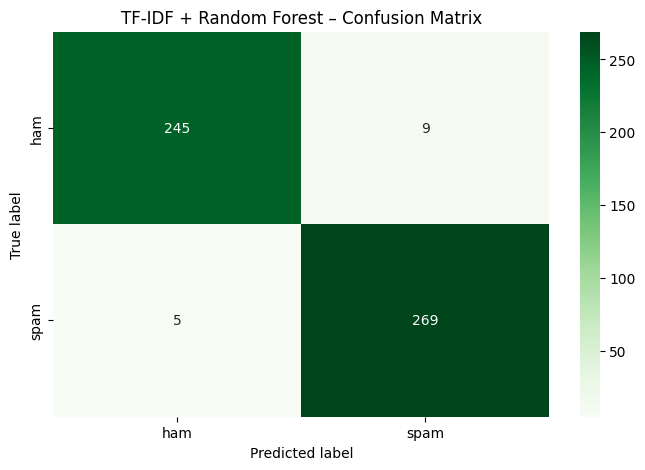

In [17]:
# ─── BLOCK 5-RF: RANDOM FOREST EVALUATION ──────────────────
print("🔍  Random Forest  —  Accuracy :", accuracy_score(y_test, rf_pred))
print("\nClassification report:\n", classification_report(y_test, rf_pred, digits=4))

cm_rf = confusion_matrix(y_test, rf_pred, labels=rf_clf.classes_)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens",
            xticklabels=rf_clf.classes_, yticklabels=rf_clf.classes_)
plt.title("TF-IDF + Random Forest – Confusion Matrix")
plt.ylabel("True label"); plt.xlabel("Predicted label")
plt.show()


In [18]:
import pickle

# Simpan model
with open("rf_model.pkl", "wb") as f:
    pickle.dump(rf_clf, f)

# Simpan vectorizer
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

print("Model dan vectorizer berhasil disimpan.")


Model dan vectorizer berhasil disimpan.


In [ ]:
# Input email dari pengguna
input_email = input("Masukkan teks email yang ingin dicek:\n")

# Preprocessing (gunakan fungsi dari notebook kamu)
cleaned = clean_text(input_email)

# Tampilkan hasil preprocessing
print("\n📋 Hasil Preprocessing:", cleaned)

# Transform ke TF-IDF
input_vector = tfidf.transform([cleaned])

# Cek berapa kata dari input yang dikenali oleh TF-IDF
print("🔍 Jumlah kata dikenali oleh model (non-zero TF-IDF features):", input_vector.nnz)

# Cek confidence score jika model mendukung (RandomForestClassifier mendukung predict_proba)
if hasattr(rf_clf, "predict_proba"):
    proba = rf_clf.predict_proba(input_vector)[0]
    print(f"📊 Probabilitas: Bukan Spam = {proba[0]:.4f}, Spam = {proba[1]:.4f}")

# Prediksi akhir
prediksi = rf_clf.predict(input_vector)[0]

if proba[1] > 0.51:
    prediksi = 1
else:
    prediksi = 0


# Output jawaban
if prediksi == 1:
    print("\n📩 Email ini terdeteksi sebagai: ❌ SPAM")
    print("🔁 Balasan otomatis: Maaf, email Anda kami tandai sebagai email spam.")
else:
    print("\n📩 Email ini terdeteksi sebagai: ✅ Bukan Spam")
    print("🔁 Balasan otomatis: Email Anda kami tandai sebagai email yang asli")
